# Дипломная работа. A/B-тестирование на базе Python и Excel. Сафиуллина Линара.

In [3]:
# 1. Импорт и анализ таблиц
    
#     1.1.   Импортируем данные в окружение *Jupyter Notebook*.
#     1.2.   Изучаем все три таблицы и проверьте их на наличие пустых значений.
#     1.3.   Исключаем из таблиц все строки, в которых есть нулловые значения. 
#     1.4. Исследуем количество торговых точек в каждом городе - строим группировку 
#     по количеству в каждом городе и визуализируем с помощью гистограммы.

In [4]:
import pandas as pd
data = pd.read_excel ('/Users/linarasafi/Desktop/Образование/Курсовая/Диплом/Новый диплом датасет.xlsx', sheet_name = 'Данные')
clients = pd.read_excel ('/Users/linarasafi/Desktop/Образование/Курсовая/Диплом/Новый диплом датасет.xlsx', sheet_name = 'Clients')
city = pd.read_excel ('/Users/linarasafi/Desktop/Образование/Курсовая/Диплом/Новый диплом датасет.xlsx', sheet_name = 'Region_dict')

In [5]:
data.describe()

,id_order,id_client,amt_payment
count,37989.000000,37401.000000,35845.000000
mean,197751.747085,194078.460710,3542.546464
std,56733.647764,8972.581221,1426.815593
min,100238.000000,178561.000000,498.000000
25%,148504.000000,186334.000000,2582.000000
50%,197658.000000,194069.000000,3470.000000
75%,246441.000000,201831.000000,4389.000000
max,297607.000000,209634.000000,7633.000000


In [6]:
data.isna().sum()

id_order          0
id_client       588
amt_payment    2144
dtime_pay      2161
dtype: int64

In [7]:
clients.describe()

,id_client,nflag_test,id_trading_point
count,55605.000000,55605.000000,55605.000000
mean,227974.818344,0.463879,1095.527363
std,45272.325725,0.498698,1642.650476
min,178561.000000,0.000000,1.000000
25%,192462.000000,0.000000,112.000000
50%,206364.000000,0.000000,516.000000
75%,262665.000000,1.000000,1101.000000
max,331964.000000,1.000000,9931.000000


In [8]:
clients.isna().sum()

id_client             0
dtime_ad            249
nflag_test            0
id_trading_point      0
dtype: int64

In [9]:
data = data.dropna(subset=['id_client','amt_payment', 'dtime_pay']) # Непонятно, что за заказы без данных о клиенте
clients = clients.dropna (subset = ['dtime_ad'])

# data ['amt_payment'] = data['amt_payment'].fillna(0) # пригодятся для расчета конверсии?
# data ['dtime_pay'] = data['dtime_pay'].fillna(0)

In [10]:
data

,id_order,id_client,amt_payment,dtime_pay
0,100238,194569.0,5373.0,2022-10-28 04:05:15.221000
1,100242,191056.0,4151.0,2022-08-01 02:42:54.992000
2,100249,200049.0,5688.0,2022-08-24 12:45:12.744000
3,100258,206161.0,4330.0,2022-12-09 15:13:26.437000
4,100267,190945.0,5488.0,2022-08-03 02:07:31.468000
...,...,...,...,...
37983,297572,195257.0,2191.0,2022-08-21 18:31:51.585000
37985,297593,179230.0,5755.0,2022-09-05 03:29:07.726000
37986,297595,192530.0,4448.0,2022-09-27 23:50:05.734000
37987,297601,183888.0,1746.0,2022-10-13 14:23:03.073000


In [11]:
pd.set_option('display.max_rows', None)

In [12]:
points_by_city = city.groupby('city')['id_trading_point'].count().reset_index()

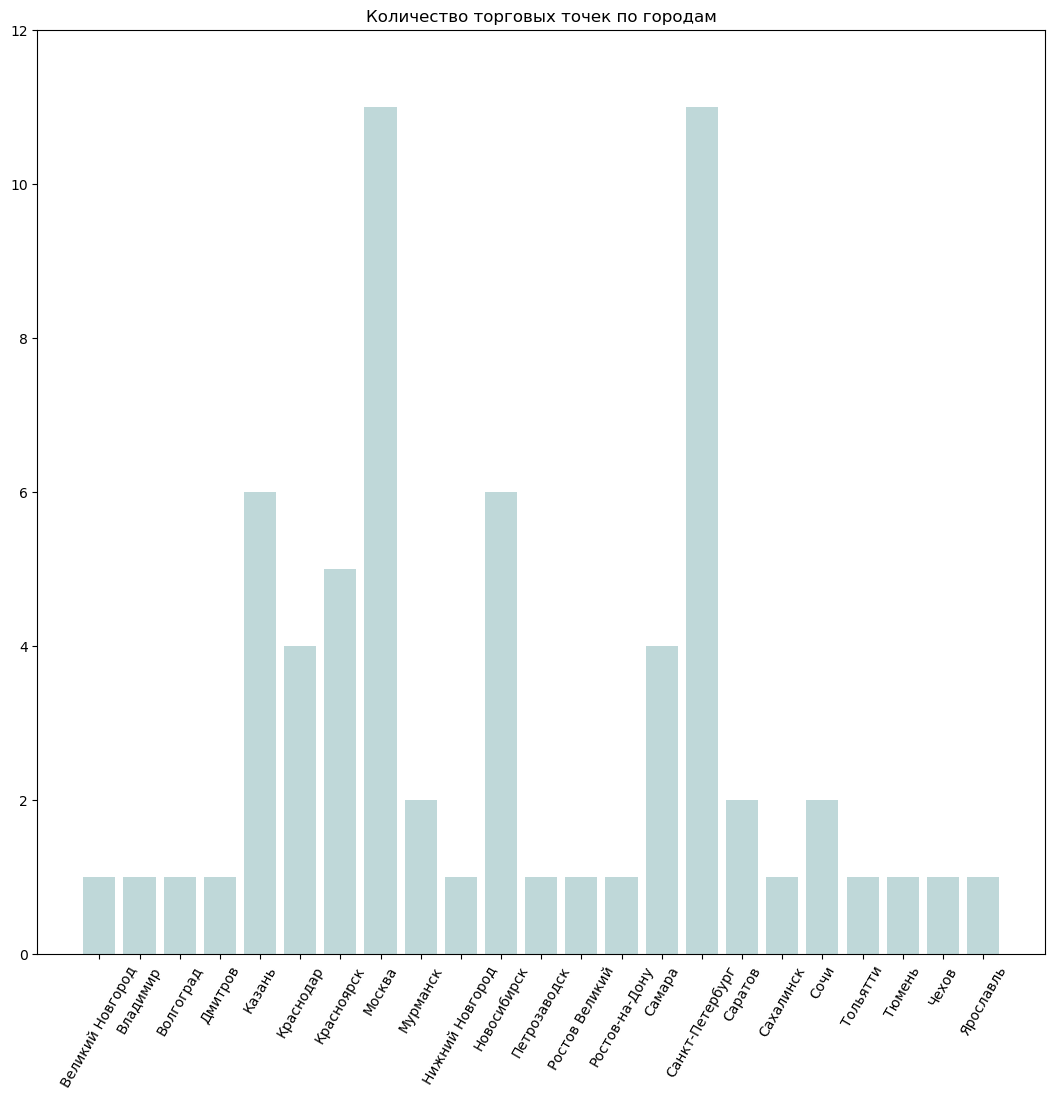

In [13]:
from matplotlib import pyplot as plt

plt.figure (figsize = (13,12))
plt.bar(points_by_city['city'],points_by_city['id_trading_point'], color = 'cadetblue', alpha = 0.4)
plt.ylim (0,12)
plt.title ('Количество торговых точек по городам')
plt.xticks(rotation=60)
plt.show()

In [14]:
# 2. Объединение таблиц
    
#     2.1.   У одного клиента может быть несколько платежей. Построем агрегацию таблицы 
#     с платежами, где вычислим сумму платежей на каждого клиента.
#     2.2.   Соединим (по клиенту) сгруппированную таблицу с платежами с клиентской таблицей.
#     Убедимся, что в таблице остались все клиенты из клиентской таблицы. 
#     2.3. Заполним нулями суммы покупок тех клиентов, которые их не совершали.
#     2.4. С помощью словаря регионов подтянем к каждой торговой точке город, 
#     в котором она находится.
#     2.5. Создаем поле флаг платежа, который принимает значения 0 или 1 в зависимости от того,
#     заплатил клиент или нет.

In [15]:
payment_by_client = data.groupby('id_client')['amt_payment'].sum().reset_index()

In [16]:
clients_payments = pd.merge (clients, payment_by_client, how = "left", left_on = 'id_client', right_on = 'id_client') 

In [17]:
clients_payments['amt_payment'] = clients_payments['amt_payment'].fillna(0)

In [18]:
full_data = pd.merge (clients_payments, city, how = "left", left_on = 'id_trading_point', right_on = 'id_trading_point')

In [19]:
import numpy as np

full_data ['flag_payment'] = np.where(full_data ['amt_payment'] > 0, 1,0)

In [20]:
# 3. Автоматизация статистических вычислений
    
#     3.1. Создаем функцию test_calc, которая будет вычислять значение t-критерия (критерия Стьюдента) 
#     и p_value для сравнения средних и с помощью функции "print" выводить сообщение о том, 
#     существует ли разница между средними (на основании p_value).
    
#     Аргументы функции: r1 (первая выборка), r2 (вторая выборка), 
#     alpha (уровень значимости - имеет значение по умолчанию 5%).
    
#     3.2. Создаtv функцию mann_whitney_func, которая будет рассчитывать значение критерия Манна Уитни 
#     и p_value для сравнения распределений и с помощью функции "print" выводить сообщение о том,
#     существует ли разница между средними (на основании p_value).
    
#     Аргументы функции: r1 (первая выборка), r2 (вторая выборка), 
#     alpha (уровень значимости - имеет значение по умолчанию 5%).

In [21]:
from scipy.stats import ttest_ind, mannwhitneyu
def test_calc (r1, r2, alpha = 0.05):
    t, p_value = ttest_ind (r1,r2)
    
    if p_value < alpha:
        print("Гипотеза H0 о равенстве средних опровергается. Cредние не равны")
    else:
        print("Гипотеза не опровергается. Не удалось статистически значимо зафиксировать разницу средних")
    
    print("Среднее значение 1 ряда", r1.mean())
    print("Среднее значение 2 ряда", r2.mean())
    print("Разница средних = ", r1.mean()-r2.mean())
    print("P_value = ",p_value)
    return t, p_value


In [22]:
def mann_whitney_func (r1_mw, r2_mw, alpha = 0.05):
    t_mw, p_value_mw = ttest_ind (r1_mw,r2_mw)
    
    if p_value_mw < alpha:
        print("Гипотеза H0 опровергается: выборки распределены не одинаково")
    else:
        print("Гипотеза H0 не опровергается: Не удалось статистически значимо зафиксировать разницу распределения выборок")

    print("P_value = ", p_value_mw)
    return  t_mw, p_value_mw

In [23]:
# 4. Чистка неверно заполненных точек
    
#     4.1.  Создаем пустой список. Запускаем цикл по всем торговым точкам и добавляем 
#     к этому списку все торговые точки, в которых не было заплачено ни одного рубля 
#     ни одним клиентом.
    
#     4.2. Создаем еще один пустой список. Запускаем цикл по всем торговым точкам и 
#     добавляем к этому списку все торговые точки, в которых пустует или контрольная, 
#     или тестовая группа.

In [24]:
trading_point_out = []

for point in full_data['id_trading_point'].unique():
    df_ = full_data[full_data['id_trading_point'] == point] 
    if df_['flag_payment'].sum() == 0:
        trading_point_out.append(point)

In [25]:
trading_point_out_2 = []

for point_2 in full_data['id_trading_point'].unique():
    df_2 = full_data[full_data['id_trading_point'] == point_2]
    if df_2['nflag_test'].sum()/df_2['nflag_test'].count() == 1 or df_2['nflag_test'].sum() == 0:    
        trading_point_out_2.append(point_2)

In [26]:
trading_point_out_3 = []

for point_3 in full_data['id_trading_point'].unique():
    df_3 = full_data[full_data['id_trading_point'] == point_3] 
    if df_3[df_3['nflag_test']==1]['amt_payment'].sum() == 0 or df_3[df_3['nflag_test']==0]['amt_payment'].sum() == 0:
        trading_point_out_3.append(point_3)

In [27]:
trading_points_out_list = trading_point_out + trading_point_out_2 + trading_point_out_3
print(trading_points_out_list)

[26, 7, 23, 4, 1, 13, 1015, 866, 1099, 739, 228, 603, 810, 800, 1015, 866, 1099, 739, 46, 228, 26, 603, 810, 800, 7, 23, 4, 1, 13]


In [28]:
# 5. Расчет общих результатов АБ Теста
    
#     5.1. Отбросываем все торговые точки, которые были вами обнаружены в пункте 4.
#     5.2. Изображаем гистограмму платежей, на которой различными цветами изображены 
#     группы “тест” и “контроль”. 
#     5.3. Применяем функцию test_calc и делаем вывод (сравниваем средние платежи)
#     5.4. Применяем функцию test_calc и делаем вывод (сравниваем конверсию в платеж, 
#     то есть *r1* и *r2* - это ряды нулей и единиц, в зависимости от того, 
#     оплатил ли что-то клиент или нет).
#     5.5. Применяем функцию mann_whitney_func и делаем вывод.

In [29]:
full_data_cleared = full_data[~full_data['id_trading_point'].isin(trading_points_out_list)]

In [30]:
full_data_cleared.head()

,id_client,dtime_ad,nflag_test,id_trading_point,amt_payment,city,flag_payment
0,180844,2022-06-08 18:38:41.414,0,212,5349.0,Красноярск,1
1,226069,2022-07-11 16:28:38.511,1,54,0.0,Мурманск,0
2,183981,2022-06-16 12:23:59.289,1,991,6322.0,Казань,1
4,254313,2022-06-19 22:18:01.770,1,453,0.0,Санкт-Петербург,0
5,195818,2022-07-16 01:30:59.088,1,2652,4021.0,Москва,1


Text(0.5, 1.0, 'Распределение платежей контрольной (0) и тестовой (1) групп')

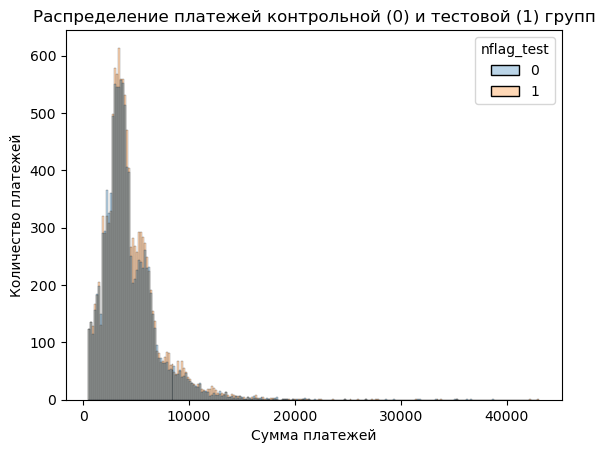

In [31]:
import seaborn as sns
sns.histplot(data=full_data_cleared.query('amt_payment != 0'), 
             x = 'amt_payment', 
             hue='nflag_test', 
             alpha =0.3)
plt.xlabel('Cумма платежей')
plt.ylabel('Количество платежей')
plt.title ("Распределение платежей контрольной (0) и тестовой (1) групп")

In [32]:
t, p_value = test_calc(full_data_cleared[(full_data_cleared['nflag_test']== 1) & 
                    (full_data_cleared['amt_payment'] != 0)]['amt_payment'], 
                    full_data_cleared[(full_data_cleared['nflag_test']== 0) & 
                    (full_data_cleared['amt_payment'] != 0)]['amt_payment'], alpha = 0.05)

Гипотеза H0 о равенстве средних опровергается. Cредние не равны
Среднее значение 1 ряда 4513.807200262424
Среднее значение 2 ряда 4380.483509754177
Разница средних =  133.32369050824673
P_value =  0.00016232976861292226


In [33]:
t, p_value = test_calc(full_data_cleared[full_data_cleared['nflag_test']== 1]['flag_payment'], 
                       full_data_cleared[full_data_cleared['nflag_test']== 0]['flag_payment'], alpha = 0.05)

Гипотеза H0 о равенстве средних опровергается. Cредние не равны
Среднее значение 1 ряда 0.5432835820895522
Среднее значение 2 ряда 0.49975954181786386
Разница средних =  0.043524040271688325
P_value =  1.7338073027564523e-20


In [34]:
t_mw, p_value_mw = mann_whitney_func(full_data_cleared[full_data_cleared['nflag_test']== 1] ['flag_payment'], 
                                     full_data_cleared[full_data_cleared['nflag_test']==0]['flag_payment'], alpha = 0.05)

Гипотеза H0 опровергается: выборки распределены не одинаково
P_value =  1.7338073027564523e-20


In [35]:

def plot_payments_distribution(df, segment_columns, test_factor):
    for segment in segment_columns:
        aggregated_data = df.groupby(by = [test_factor, segment])['id_client'].count().reset_index()
        plt.figure(figsize = (15,12))
        sns.catplot(x = segment, 
                    y = 'id_client', 
                    hue = test_factor,
                    data = aggregated_data, 
                    kind = "bar", 
                    height = 6,
                    aspect = 1.5)
        plt.xticks (rotation = 45)
        plt.xlabel('Город')
        plt.ylabel('Количество платежей')
        plt.title ("Распределение платежей по городам внутри контрольной (0) и тестовой (1) групп")

<Figure size 1500x1200 with 0 Axes>

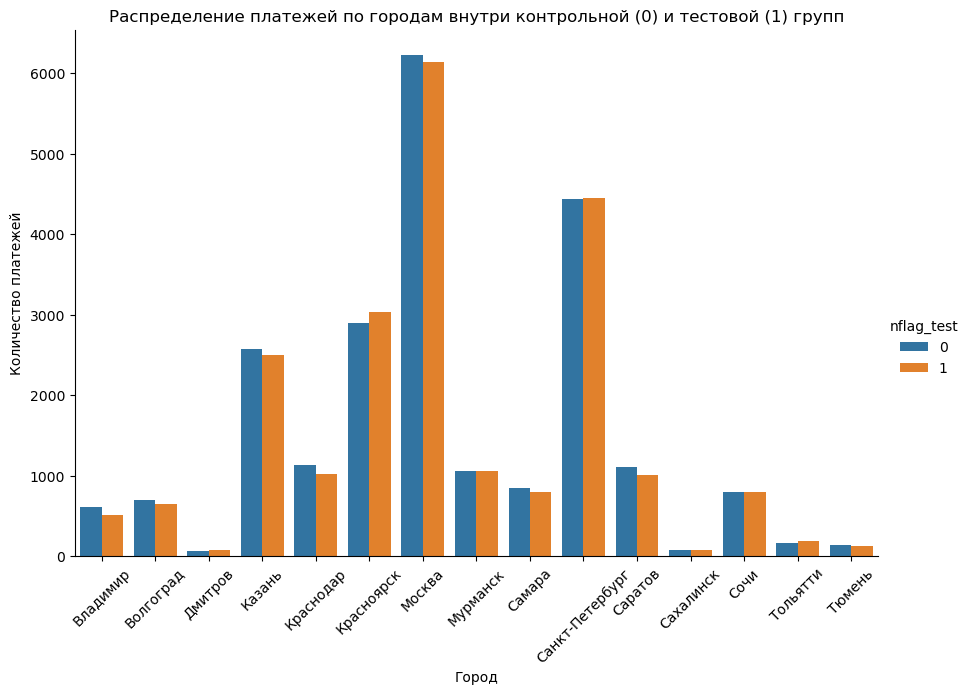

In [36]:
plot_payments_distribution(full_data_cleared,
                           ["city"],
                           "nflag_test")

In [37]:
# На основе полученных данных АБ-теста, мы можем определенно сказать, что средние платежи и 
# конверсия в покупку в контрольной и тестовой группах статистически существенно отличаются, 
# значит наше нововведение работает. 
# Выборки тестовой и контрольной группы распредлены одинаково.

# Согласно гистограмме выше, мы видим , что разница в данных между тестовой и контрольной 
# группой различаются в разных городах, поэтому для будущего корректного использования 
# результатов теста рассмотрим результаты сегментарно.
# Наиболее приоритетными по объему = Москва и Санкт-Петербург

In [38]:
# 6. Сегментация результатов АБ Теста
    
#     6.1.  Москва
    
#     6.1.1. Проанализируем данные из пункта 5 в отношении Москвы. Сделаем выводы.
    
#     6.2.  Санкт-Петербург
    
#     6.2.1. Проанализируем данные из пункта 5 в отношении Санкт-Петербурга. Сделаем выводы.
    
#     6.3. Другие города
    
#     6.3.1. Запустим цикл по оставшимся городам. Проведем такой же анализ.

In [39]:
full_data_cleared_msk = full_data_cleared.loc[full_data_cleared['city'] == 'Москва']

In [40]:
full_data_cleared_spb = full_data_cleared.loc[full_data_cleared['city'] == 'Санкт-Петербург']

In [41]:
# Сравниваем средние платежи по Москве (контроль/тест)

t_msk, p_value_msk= test_calc(full_data_cleared_msk[(full_data_cleared_msk['nflag_test']== 1) & 
                    (full_data_cleared_msk['amt_payment'] != 0)]['amt_payment'], 
                    full_data_cleared_msk[(full_data_cleared_msk['nflag_test']== 0) & 
                    (full_data_cleared_msk['amt_payment'] != 0)]['amt_payment'], alpha = 0.05)

Гипотеза H0 о равенстве средних опровергается. Cредние не равны
Среднее значение 1 ряда 4356.646970605879
Среднее значение 2 ряда 4070.460322686862
Разница средних =  286.18664791901665
P_value =  5.0615538078886085e-06


In [42]:
# Сравниваем конверсию в платеж по Москве (контроль/тест)
t_msk, p_value_msk= test_calc(full_data_cleared_msk[full_data_cleared_msk['nflag_test']== 1]['flag_payment'], 
                       full_data_cleared_msk[full_data_cleared_msk['nflag_test']== 0]['flag_payment'], alpha = 0.05)

Гипотеза H0 о равенстве средних опровергается. Cредние не равны
Среднее значение 1 ряда 0.5435278774046299
Среднее значение 2 ряда 0.4879498714652956
Разница средних =  0.05557800593933432
P_value =  6.194689260032594e-10


In [43]:
t_mw_msk, p_value_mw_msk = mann_whitney_func(full_data_cleared_msk[full_data_cleared_msk['nflag_test']== 1] ['flag_payment'], 
                                     full_data_cleared_msk[full_data_cleared_msk['nflag_test']==0]['flag_payment'], alpha = 0.05)

Гипотеза H0 опровергается: выборки распределены не одинаково
P_value =  6.194689260032594e-10


Text(0.5, 1.0, 'Распределение платежей контрольной (0) и тестовой (1) групп в Москве')

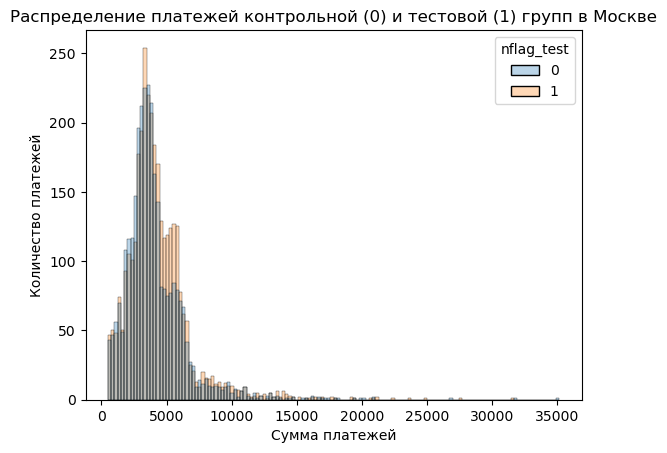

In [44]:
import seaborn as sns
sns.histplot(data=full_data_cleared_msk.query('amt_payment != 0'), 
             x = 'amt_payment', 
             hue='nflag_test', 
             alpha =0.3)
plt.xlabel('Cумма платежей')
plt.ylabel('Количество платежей')
plt.title ("Распределение платежей контрольной (0) и тестовой (1) групп в Москве")

In [45]:
# Сравниваем средние платежи по Санкт-Петербургу (контроль/тест)
t_spb, p_value_spb= test_calc(full_data_cleared_spb[(full_data_cleared_spb['nflag_test']== 1) & 
                    (full_data_cleared_spb['amt_payment'] != 0)]['amt_payment'], 
                    full_data_cleared_spb[(full_data_cleared_spb['nflag_test']== 0) & 
                    (full_data_cleared_spb['amt_payment'] != 0)]['amt_payment'], alpha = 0.05)

Гипотеза H0 о равенстве средних опровергается. Cредние не равны
Среднее значение 1 ряда 4436.706825657895
Среднее значение 2 ряда 4267.9673038229375
Разница средних =  168.7395218349575
P_value =  0.021879269472817743


In [46]:
# Сравниваем конверсию в платеж по Санкт-Петербургу (контроль/тест)
t_spb, p_value_spb= test_calc(full_data_cleared_spb[full_data_cleared_spb['nflag_test']== 1]['flag_payment'], 
                       full_data_cleared_spb[full_data_cleared_spb['nflag_test']== 0]['flag_payment'], alpha = 0.05)

Гипотеза H0 о равенстве средних опровергается. Cредние не равны
Среднее значение 1 ряда 0.5471316085489314
Среднее значение 2 ряда 0.44835363103292736
Разница средних =  0.09877797751600403
P_value =  1.065825659919673e-20


In [47]:
t_mw_spb, p_value_mw_spb = mann_whitney_func(full_data_cleared_spb[full_data_cleared_spb['nflag_test']== 1] ['flag_payment'], 
                                     full_data_cleared_spb[full_data_cleared_spb['nflag_test']==0]['flag_payment'], alpha = 0.05)

Гипотеза H0 опровергается: выборки распределены не одинаково
P_value =  1.065825659919673e-20


Text(0.5, 1.0, 'Распределение платежей контрольной (0) и тестовой (1) групп в Санкт-Петербурге')

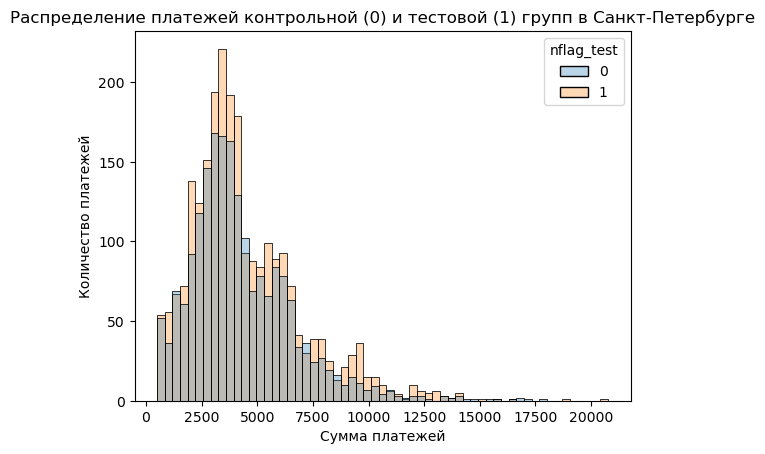

In [48]:
import seaborn as sns
sns.histplot(data=full_data_cleared_spb.query('amt_payment != 0'), 
             x = 'amt_payment', 
             hue='nflag_test', 
             alpha =0.3)
plt.xlabel('Cумма платежей')
plt.ylabel('Количество платежей')
plt.title ("Распределение платежей контрольной (0) и тестовой (1) групп в Санкт-Петербурге")

In [49]:
# И по Москве, и по Санкт-Петербургу мы наблюдаем такой же тренд, как и по общим данным. 
# Средние платежи и конверсии в покупку в обоих городах значительно отличаются в контрольной и тестовой группе:
# в контрольных группах - ниже.
# Но выборки для анализа распределены не одинаково.

In [50]:
#Запускаем цикл по оставшимся городам.

city_others = []
for city in full_data_cleared['city'].unique(): 
    if (city != 'Москва') and (city !='Санкт-Петербург'):
        city_others.append(city)

In [51]:
city_others

['Красноярск',
 'Мурманск',
 'Казань',
 'Саратов',
 'Тольятти',
 'Тюмень',
 'Волгоград',
 'Сочи',
 'Владимир',
 'Самара',
 'Краснодар',
 'Сахалинск',
 'Дмитров']

In [52]:
for city_cat in full_data_cleared['city'].unique():
    if city_cat in city_others:
        full_data_cleared_others = full_data_cleared[full_data_cleared['city']== city_cat]
        print(city_cat)
        print()
        test_calc(full_data_cleared_others[(full_data_cleared_others['nflag_test']== 1) & 
                    (full_data_cleared_others['amt_payment'] != 0)]['amt_payment'], 
                    full_data_cleared_others[(full_data_cleared_others['nflag_test']== 0) & 
                    (full_data_cleared_others['amt_payment'] != 0)]['amt_payment'], alpha = 0.05)
        print()

Красноярск

Гипотеза не опровергается. Не удалось статистически значимо зафиксировать разницу средних
Среднее значение 1 ряда 4369.938016528926
Среднее значение 2 ряда 4326.44656019656
Разница средних =  43.49145633236549
P_value =  0.5984752086062595

Мурманск

Гипотеза не опровергается. Не удалось статистически значимо зафиксировать разницу средних
Среднее значение 1 ряда 4268.678958785249
Среднее значение 2 ряда 4434.840807174888
Разница средних =  -166.1618483896391
P_value =  0.30802785459679893

Казань

Гипотеза не опровергается. Не удалось статистически значимо зафиксировать разницу средних
Среднее значение 1 ряда 5705.750208855472
Среднее значение 2 ряда 5496.522875816993
Разница средних =  209.22733303847872
P_value =  0.22565168709550387

Саратов

Гипотеза не опровергается. Не удалось статистически значимо зафиксировать разницу средних
Среднее значение 1 ряда 4298.092281879195
Среднее значение 2 ряда 4424.937205651491
Разница средних =  -126.84492377229617
P_value =  0.348474

In [53]:
for city_cat in full_data_cleared['city'].unique():
    if city_cat in city_others:
        full_data_cleared_others = full_data_cleared[full_data_cleared['city']== city_cat]
        print(city_cat)
        print()
        test_calc(full_data_cleared_others[full_data_cleared_others['nflag_test']== 1]['flag_payment'], 
                       full_data_cleared_others[full_data_cleared_others['nflag_test']== 0]['flag_payment'], alpha = 0.05)
        print()

Красноярск

Гипотеза не опровергается. Не удалось статистически значимо зафиксировать разницу средних
Среднее значение 1 ряда 0.5577872900889035
Среднее значение 2 ряда 0.5613793103448276
Разница средних =  -0.003592020255924089
P_value =  0.7805336501430107

Мурманск

Гипотеза не опровергается. Не удалось статистически значимо зафиксировать разницу средних
Среднее значение 1 ряда 0.4369668246445498
Среднее значение 2 ряда 0.4187793427230047
Разница средних =  0.018187481921545068
P_value =  0.3976422846466432

Казань

Гипотеза не опровергается. Не удалось статистически значимо зафиксировать разницу средних
Среднее значение 1 ряда 0.4788
Среднее значение 2 ряда 0.47497089639115253
Разница средних =  0.003829103608847473
P_value =  0.784829789025573

Саратов

Гипотеза не опровергается. Не удалось статистически значимо зафиксировать разницу средних
Среднее значение 1 ряда 0.5883514313919053
Среднее значение 2 ряда 0.5743913435527502
Разница средних =  0.013960087839155033
P_value =  0.51

In [54]:
for city_cat in full_data_cleared['city'].unique():
    if city_cat in city_others:
        full_data_cleared_others = full_data_cleared[full_data_cleared['city']== city_cat]
        print(city_cat)
        print()
        mann_whitney_func(full_data_cleared_others[full_data_cleared_others['nflag_test']== 1] ['flag_payment'], 
                            full_data_cleared_others[full_data_cleared_others['nflag_test']==0]['flag_payment'], alpha = 0.05)
        print()

Красноярск

Гипотеза H0 не опровергается: Не удалось статистически значимо зафиксировать разницу распределения выборок
P_value =  0.7805336501430107

Мурманск

Гипотеза H0 не опровергается: Не удалось статистически значимо зафиксировать разницу распределения выборок
P_value =  0.3976422846466432

Казань

Гипотеза H0 не опровергается: Не удалось статистически значимо зафиксировать разницу распределения выборок
P_value =  0.784829789025573

Саратов

Гипотеза H0 не опровергается: Не удалось статистически значимо зафиксировать разницу распределения выборок
P_value =  0.5152558091282406

Тольятти

Гипотеза H0 не опровергается: Не удалось статистически значимо зафиксировать разницу распределения выборок
P_value =  0.23675311799785545

Тюмень

Гипотеза H0 опровергается: выборки распределены не одинаково
P_value =  0.014518259322133286

Волгоград

Гипотеза H0 не опровергается: Не удалось статистически значимо зафиксировать разницу распределения выборок
P_value =  0.10498894497258296

Сочи

Гип

Красноярск


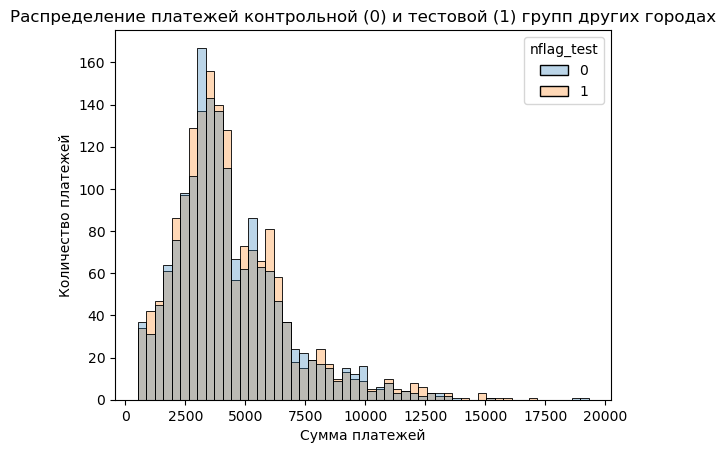

Мурманск


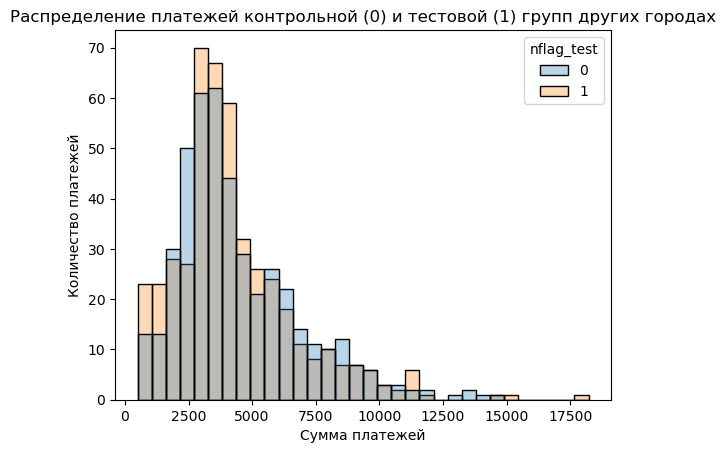

Казань


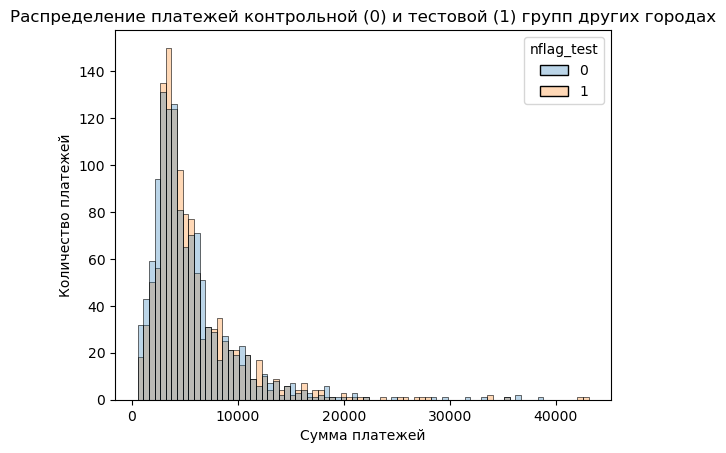

Саратов


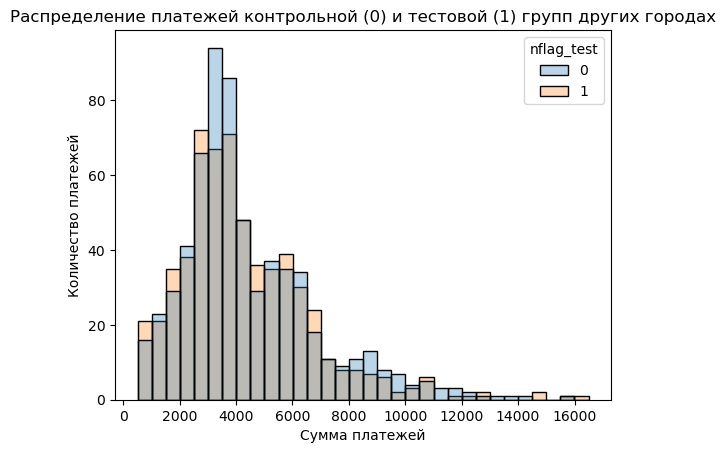

Тольятти


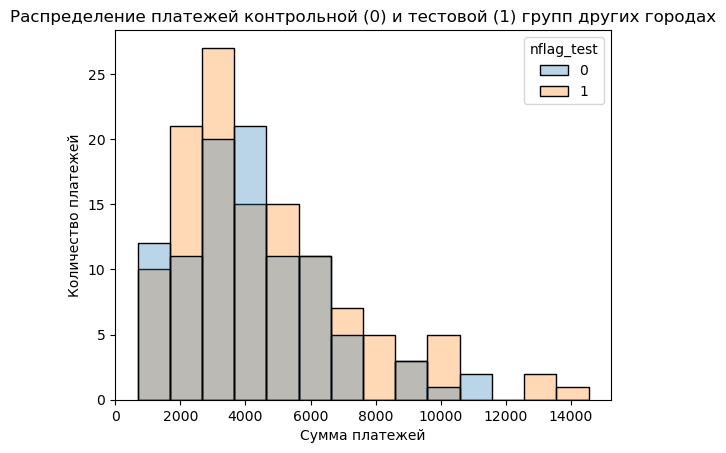

Тюмень


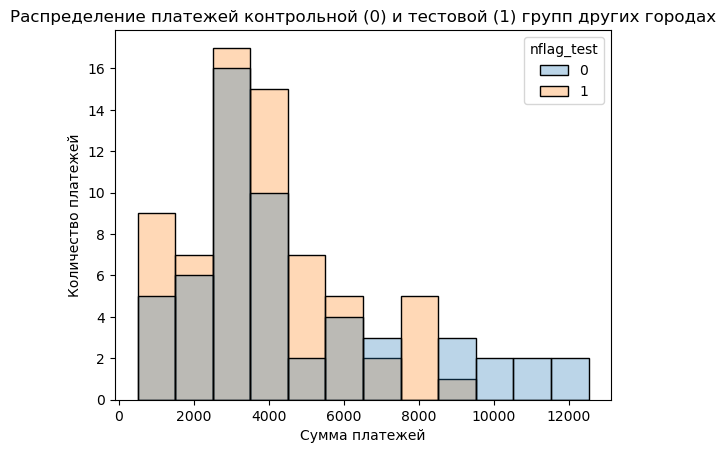

Волгоград


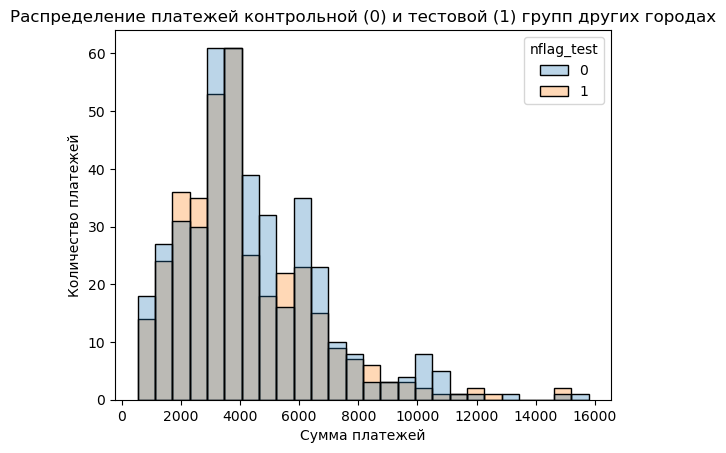

Сочи


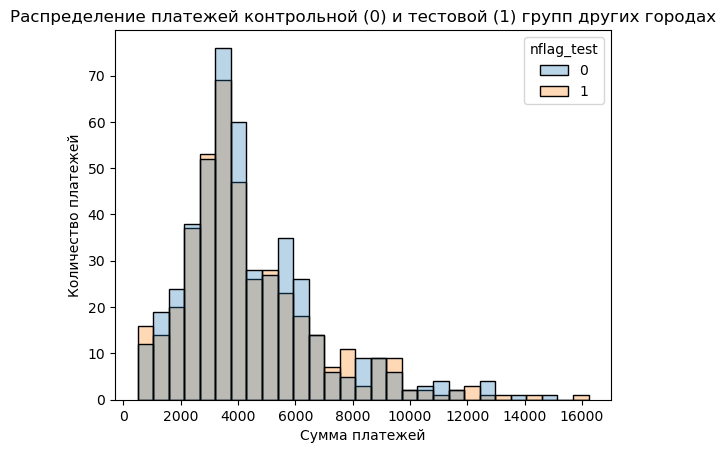

Владимир


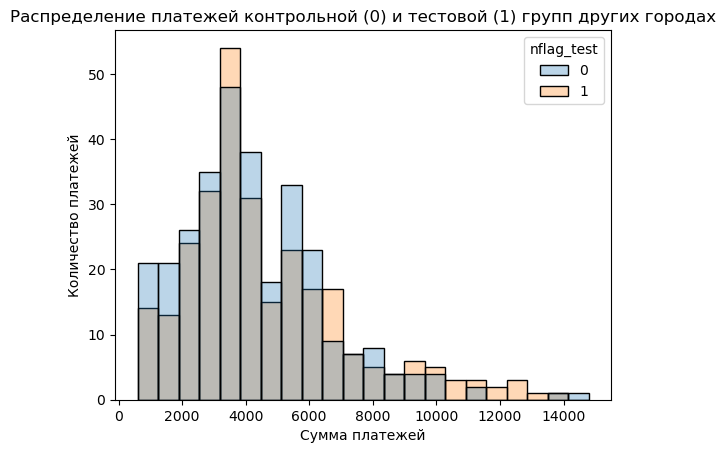

Самара


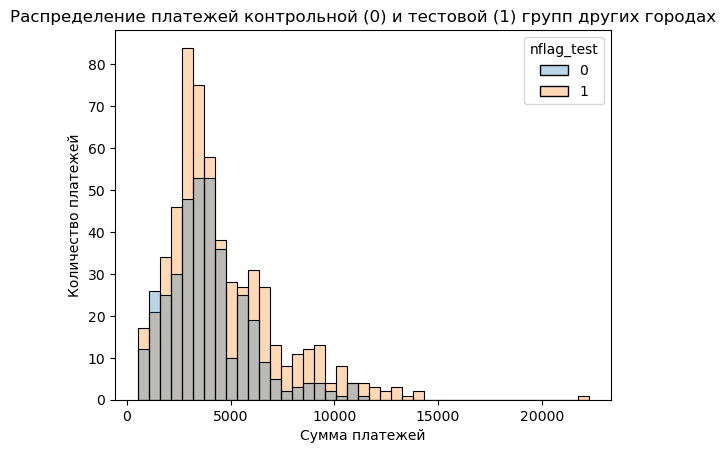

Краснодар


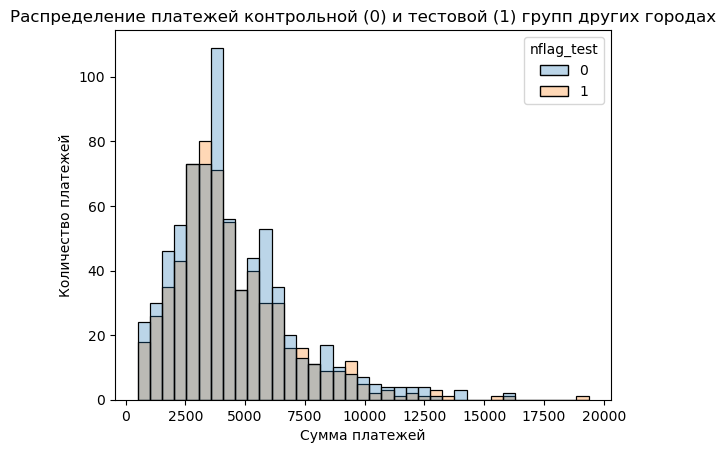

Сахалинск


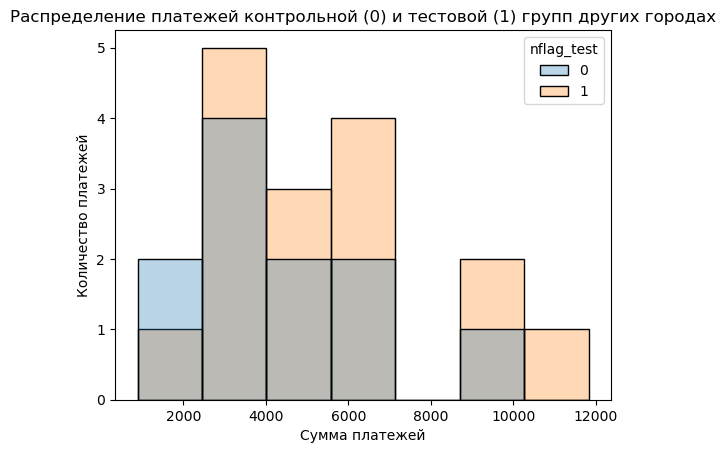

Дмитров


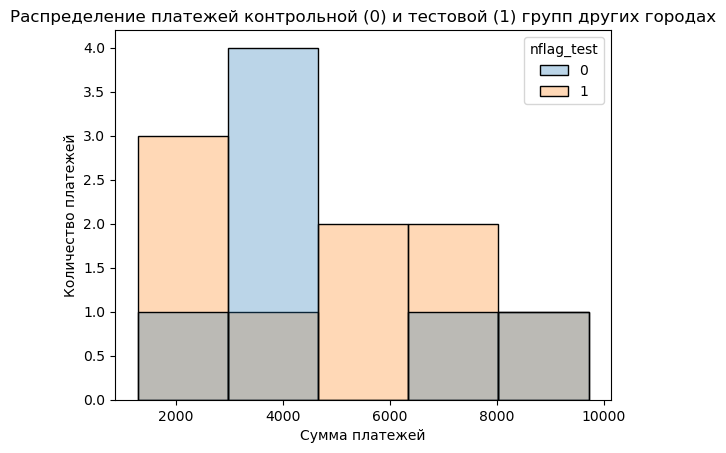

In [55]:
import seaborn as sns
for city_cat in full_data_cleared['city'].unique():
    if city_cat in city_others:
        full_data_cleared_others = full_data_cleared[full_data_cleared['city']== city_cat]
        sns.histplot(data=full_data_cleared_others.query('amt_payment != 0'), 
             x = 'amt_payment', 
             hue='nflag_test',
             alpha =0.3)
        plt.xlabel('Cумма платежей')
        plt.ylabel('Количество платежей')
        plt.title ("Распределение платежей контрольной (0) и тестовой (1) групп других городах")
        print(city_cat)
        plt.show()

In [57]:
# 7. Отчет по АБ Тесту
    
#     Создаем пустой датафрейм. Запустим цикл по всем городам и торговым точкам. 
    
#     Заполним для каждой торговой точки все поля, указанные в требовании к таблице ниже. 
    
#     Задаем один из трех лейблов, в зависимости от результата теста в данной торговой точке.
    
#     Выгружаем полученные результаты в Excel и разносим результаты по трем разным листам в зависимости от лейбла.

In [58]:
# Таблица, которая должна быть сформирована в результате исследования должна показывать для каждой торговой 
# точки результат исследования. 
# Перед составлением этой таблицы должны быть очищены данные, то есть удалены торговые точки, имеющие нулевые 
# платежи или нулевое количество клиентов в контрольной или тестовой группе.

# Поля таблицы должны быть следующими:

# - city - город
# - id_trading_point  - уникальный идентификатор торговой точки, к которой прикреплен данный пользователь
# - count_test - кол-во наблюдений в тестовой группе
# - count_control - кол-во наблюдений в контрольной группе
# - count_all - суммарное кол-во наблюдений
# - percent_count - процент кол-ва наблюдений данной ТТ от всех наблюдений
# - avg_payment_test - средний платеж в тестовой группе
# - avg_payment_control - средний платеж в контрольной группе
# - diff - разница между средними платежами
# - sigma_test - стандартное отклонение платежей в тестовой группе
# - sigma_control - стандартное отклонение платежей в контрольной группе
# - ttest - значение статистического критерия (критерий Стьюдента для сравнения средних платежей)
# - pvalue_ttest - pvalue статистического критерия (критерий Стьюдента для сравнения средних платежей)

# В таблице также должен присутствовать флаг (лейбл), по которому можно будет разделить торговые точки по результатам эксперимента
# - Если результат (поле diff) положительный, и разница на самом деле есть (на основании p_value), то это положительный исход
# - Если результат (поле diff) отрицательный, и разница на самом деле есть (на основании p_value), то это отрицательный исход
# - Если разницы на самом деле нет (на основании p_value), то это нейтральный исход

In [59]:
AB_test_results = pd.DataFrame({})

In [60]:
for city_st in full_data_cleared['city'].unique():
    df_a = full_data_cleared[full_data_cleared['city'] == city_st] 
    for point_st in df_a['id_trading_point'].unique():
        df_b = df_a[df_a['id_trading_point'] == point_st] 
        count_test = len(df_b[df_b['nflag_test']== 1])
        count_control = len(df_b[df_b['nflag_test']== 0])
        count_all = count_test + count_control
        percent_count = count_test/count_all*100
        avg_payment_test = np.mean(df_b[df_b['nflag_test']== 1])['amt_payment']
        avg_payment_control = np.mean(df_b[df_b['nflag_test']== 0])['amt_payment']
        diff=avg_payment_test-avg_payment_control
        sigma_test= df_b[df_b['nflag_test']== 1]['amt_payment'].std()
        sigma_control = df_b[df_b['nflag_test']== 0]['amt_payment'].std()
        ttest, pvalue_ttest = test_calc(df_b[df_b['nflag_test']== 1]['amt_payment'], 
                                        df_b[df_b['nflag_test']== 0]['amt_payment'], alpha = 0.05)
        AB_test_results = AB_test_results.append({'city':city_st, 'id_trading_point':point_st, 'count_test':count_test, 
                                          'count_control':count_control, 'count_all':count_all, 'percent_count': percent_count,
                                          'avg_payment_test':avg_payment_test, 'avg_payment_control':avg_payment_control, 
                                          'diff':diff, 'sigma_test':sigma_test, 'sigma_control':sigma_control, 
                                          'ttest':ttest, 'pvalue_ttest':pvalue_ttest}, ignore_index = True)

Гипотеза не опровергается. Не удалось статистически значимо зафиксировать разницу средних
Среднее значение 1 ряда 2144.317032040472
Среднее значение 2 ряда 2222.0521739130436
Разница средних =  -77.7351418725716
P_value =  0.6287709476405416
Гипотеза не опровергается. Не удалось статистически значимо зафиксировать разницу средних
Среднее значение 1 ряда 2499.345794392523
Среднее значение 2 ряда 2185.2147239263804
Разница средних =  314.1310704661428
P_value =  0.06901056074583502
Гипотеза не опровергается. Не удалось статистически значимо зафиксировать разницу средних
Среднее значение 1 ряда 2927.3411978221416
Среднее значение 2 ряда 2730.378761061947
Разница средних =  196.96243676019458
P_value =  0.24830826390447136
Гипотеза не опровергается. Не удалось статистически значимо зафиксировать разницу средних
Среднее значение 1 ряда 2404.106153846154
Среднее значение 2 ряда 2545.73487544484
Разница средних =  -141.62872159868584
P_value =  0.3808017001028424
Гипотеза не опровергается. Не

/Users/linarasafi/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/linarasafi/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/linarasafi/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return

In [61]:
AB_test_results

,city,id_trading_point,count_test,count_control,count_all,percent_count,avg_payment_test,avg_payment_control,diff,sigma_test,sigma_control,ttest,pvalue_ttest
0,Красноярск,212,593,575,1168,50.770548,2144.317032,2222.052174,-77.735142,2708.588724,2785.116250,-0.483585,6.287709e-01
1,Красноярск,278,535,489,1024,52.246094,2499.345794,2185.214724,314.131070,2915.995329,2574.915597,1.820268,6.901056e-02
2,Красноярск,202,551,565,1116,49.372760,2927.341198,2730.378761,196.962437,2956.686241,2737.885785,1.155073,2.483083e-01
3,Красноярск,444,650,562,1212,53.630363,2404.106154,2545.734875,-141.628722,2810.828487,2797.138764,-0.876740,3.808017e-01
4,Красноярск,277,708,709,1417,49.964714,2285.750000,2431.365303,-145.615303,2712.677878,2868.587569,-0.981705,3.264128e-01
5,Мурманск,54,633,640,1273,49.725059,1702.714060,1688.512500,14.201560,2565.132440,2628.012490,0.097556,9.223005e-01
6,Мурманск,55,422,425,847,49.822904,2109.106635,2111.272941,-2.166306,2790.993385,2804.223188,-0.011268,9.910125e-01
7,Казань,991,270,294,564,47.872340,3249.281481,2452.986395,796.295087,4719.592601,3633.935858,2.255258,2.450100e-02
8,Казань,699,482,494,976,49.385246,2422.286307,2574.352227,-152.065920,3906.817897,4082.851356,-0.594254,5.524804e-01
9,Казань,477,382,386,768,49.739583,2259.623037,2496.987047,-237.364010,3482.846094,3881.994719,-0.891593,3.728909e-01


In [62]:
conditions = [
    (AB_test_results ['diff'] > 0) & (AB_test_results['pvalue_ttest'] < 0.05),
    (AB_test_results ['diff'] < 0) & (AB_test_results['pvalue_ttest'] < 0.05),
    (AB_test_results['pvalue_ttest'] >= 0.05)]
 
values = ['Положительный', 'Отрицательный', 'Нейтральный']
AB_test_results ['label'] = np.select(conditions, values)

In [62]:
exit()

In [1]:
pip install XlsxWriter

Note: you may need to restart the kernel to use updated packages.


In [63]:
import xlsxwriter
import pandas as pd

writer = pd.ExcelWriter('Дипломн_A_B-тест_Excel_Сафиуллина Линара.xlsx', engine ='xlsxwriter')

AB_test_results[AB_test_results['label']== "Положительный"].to_excel(writer, sheet_name = "Положительный")
AB_test_results[AB_test_results['label']== "Отрицательный"].to_excel(writer, sheet_name = "Отрицательный")
AB_test_results[AB_test_results['label']== "Нейтральный"].to_excel(writer, sheet_name = "Нейтральный")

writer.save()

/var/folders/wl/qnzd7cls2dn96mlr48c6r7rc0000gn/T/ipykernel_34789/598482764.py:10: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()
